In [150]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [151]:
# 調字體
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:/windows/fonts/msjhl.ttc", size=10)
font_params = {
    'font.family': 'Microsoft JhengHei',  # Use the correct font name for your system
    'axes.unicode_minus': False,  # To handle minus sign display
}
plt.rcParams.update(font_params)

In [152]:
from sklearn.preprocessing import MinMaxScaler

In [153]:
# 看有沒有gpu可以幫忙加速，否則用gpu(cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [154]:
# 設定要抓取的檔案
STOCK_CODE = 2330
START_YEAR = 2013
END_YEAR = 2023

filePath = f"stock{STOCK_CODE}_{START_YEAR}to{END_YEAR}.csv"

In [155]:
# 載入檔案轉成Dataframe，並修改成我們要的形式
df_raw = pd.read_csv(filePath, encoding = "big5")
df = df_raw[["日期", "開盤價", "最高價", "最低價", "收盤價", "成交股數"]]

df.loc[:, '日期'] = pd.to_datetime(df.loc[:, '日期']) # 將 "日期" 列複製為日期時間對象

df.set_index("日期", inplace=True) # 將 "日期" 列設置為索引

sel_col = ["開盤價", "最高價", "最低價", "收盤價"]   
df = df[sel_col]

scaler = MinMaxScaler(feature_range=(-1, 1))  # 把數據轉成-1~1之間
for col in sel_col: # 这里不能进行统一进行缩放，因为fit_transform返回值是numpy类型
    df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

df['target'] = df['收盤價'].shift(-1)  

df.dropna(inplace=True)     # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
df = df.astype(np.float32)  # 修改数据类型

c:\forPythonEnv\anaconda3\envs\pytorch_ver0\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [156]:
# 生成Model要輸入資料的形式(np.array)
SEQUENCE = 30

df_seq_feature = []
df_seq_target = []

for i in range(len(df) - SEQUENCE):
    df_seq_feature.append(df[["開盤價", "最高價", "最低價", "收盤價"]][i:i+SEQUENCE].values)
    df_seq_target.append(df[["target"]][i:i+SEQUENCE].values)

df_seq_feature = np.array(df_seq_feature)
df_seq_target = np.array(df_seq_target)

In [ ]:
# 把上面的np.array轉成tensor，才能丟到pytorch的model裡面
TRAIN_DATA_RATIO = 0.8
CUT_BORDER = int(len(df_seq_feature) * TRAIN_DATA_RATIO)

trainX = torch.Tensor(df_seq_feature[:CUT_BORDER]).to(device=device)
trainY = torch.Tensor(df_seq_target[:CUT_BORDER]).to(device=device)

testX = torch.Tensor(df_seq_feature[CUT_BORDER:]).to(device=device)
testY = torch.Tensor(df_seq_target[CUT_BORDER:]).to(device=device)

print(trainX.shape, testX.shape)
print(trainY.shape, testY.shape)

torch.Size([1933, 30, 4]) torch.Size([484, 30, 4])
torch.Size([1933, 30, 1]) torch.Size([484, 30, 1])


LSTM

In [ ]:
import torch.nn as nn

LSTM2_INPUT_DIM = len(sel_col)      # 數據的特徵數 (目前是INPUT_DIM=4)
LSTM2_HIDDEN_DIM = 32               # 隱藏層的神經元數
LSTM2_NUM_LAYERS = 2                # LSTM的層數
LSTM2_OUTPUT_DIM = 1                # 預測值的特徵數 (就是target)

LSTM3_INPUT_DIM = len(sel_col)      # 數據的特徵數 (目前是INPUT_DIM=4)
LSTM3_HIDDEN_DIM = 32               # 隱藏層的神經元數
LSTM3_NUM_LAYERS = 3                # LSTM的層數
LSTM3_OUTPUT_DIM = 1                # 預測值的特徵數 (就是target)

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim) 

        self.to(device=device)

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device=device) 
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device=device)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out) 

        return out

In [ ]:
# 以後會用到的模型在前面定義好以後，在這裡build然後放到List裡面
LSTM2 = LSTM(input_dim=LSTM2_INPUT_DIM, hidden_dim=LSTM2_HIDDEN_DIM, num_layers=LSTM2_NUM_LAYERS, output_dim=LSTM2_OUTPUT_DIM)
LSTM3 = LSTM(input_dim=LSTM3_INPUT_DIM, hidden_dim=LSTM3_HIDDEN_DIM, num_layers=LSTM3_NUM_LAYERS, output_dim=LSTM3_OUTPUT_DIM)
MODEL_LIST = {"LSTM2": LSTM2, "LSTM3": LSTM3}

In [ ]:
# 決定這次要用哪個MODEL
CURRENT_MODEL = "LSTM2"
model = MODEL_LIST[CURRENT_MODEL]

# 下面的code可以把model結構印出來看一下
# print(model)
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

In [ ]:
# 定義優化器和損失函數
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # 使用Adam優化
loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用MSE作為損失函數

In [ ]:
#正式訓練模型
NUM_EPOCHS = 100

loss_list = []
hist = np.zeros(NUM_EPOCHS)
for t in range(NUM_EPOCHS):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()
    
    y_train_pred = model(trainX) # Forward pass

    loss = loss_fn(y_train_pred, trainY) # 算這次的Loss
    loss_list.append(loss_fn(y_train_pred, trainY).item()) # 記載list裡面方便以後印出來
    
    if t % 10 == 0 and t !=0:                  # 每訓練十次印一下結果
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad() # Zero out gradient, else they will accumulate between epochs 將梯度歸零

    loss.backward() # Backward pass
    
    optimiser.step() # Update parameters
y_train_pred = model(trainX)
print(f'Final MSE(loss): {loss_fn(y_train_pred, trainY).item()}')

Epoch  10 MSE:  0.04158954322338104
Epoch  20 MSE:  0.022585825994610786
Epoch  30 MSE:  0.009850624017417431
Epoch  40 MSE:  0.005252765957266092
Epoch  50 MSE:  0.0037883270997554064
Epoch  60 MSE:  0.0029942095279693604
Epoch  70 MSE:  0.0023553234059363604
Epoch  80 MSE:  0.0018886837642639875
Epoch  90 MSE:  0.0015387620078399777
Final MSE(loss): 0.0012661587679758668


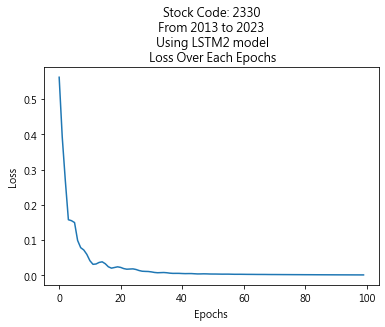

In [ ]:
plt.plot(loss_list)
plt.xlabel('Epochs') # 設定 x 軸標籤
plt.ylabel('Loss') # 設定 y 軸標籤
plt.title(f'Stock Code: {STOCK_CODE}\nFrom {START_YEAR} to {END_YEAR}\n Using {CURRENT_MODEL} model\n Loss Over Each Epochs')
plt.show()

In [ ]:
# make predictions
y_test_pred = model(testX)
loss_fn(y_test_pred, testY).item()

0.005871924106031656

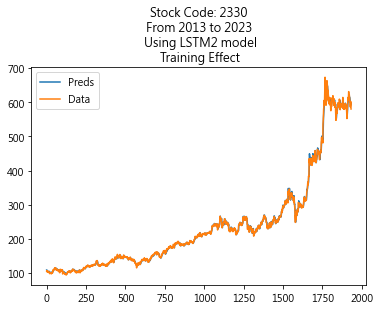

In [ ]:
# 訓練集效果圖
pred_value = y_train_pred.detach().cpu().numpy()[:,-1,0]
true_value = trainY.detach().cpu().numpy()[:,-1,0]
pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1)) # 記得還原成原本尺度
true_value = scaler.inverse_transform(true_value.reshape(-1, 1)) # 記得還原成原本尺度

plt.title(f'Stock Code: {STOCK_CODE}\nFrom {START_YEAR} to {END_YEAR}\n Using {CURRENT_MODEL} model\n Training Effect')
plt.plot(pred_value, label="Preds")    # 预测值
plt.plot(true_value, label="Data")    # 真实值
plt.legend()
plt.show()

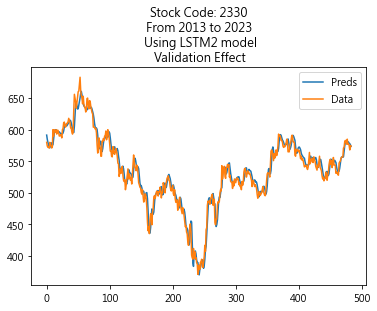

In [ ]:
# 測試效果圖
pred_value = y_test_pred.detach().cpu().numpy()[:,-1,0]    
true_value = testY.detach().cpu().numpy()[:,-1,0]

pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

plt.title(f'Stock Code: {STOCK_CODE}\nFrom {START_YEAR} to {END_YEAR}\n Using {CURRENT_MODEL} model\n Validation Effect')
plt.plot(pred_value, label="Preds")    # 预测值
plt.plot(true_value, label="Data")    # 真实值
plt.legend()
plt.show()